# Homework 3 - Attacks and Defenses in Federated Learning

## infrastructure

Based on a variant of FedAvg that updates parameter differences rather than a complete.
As regular FedAvg, this variant performs multiple local epochs.
Unlike regular FedAvg, clients now determine the deviation of their local parameters from the servers' parameters and upload the differences to the server.
Perhaps surprisingly, these differences are referred to as "gradients".

This variant is pretty much equivalent to the original one but makes it easier to reason about updates.

In [1]:
# Also includes all the dependencies of this module, as the dependencies are members of that module
import typing

from fedavg import *
from matplotlib import pyplot as plt

if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator()
    print(f"Using accelerator '{device}'")
else:
    device = torch.device("cpu")
    print("WARN: No accelerator found, running on CPU")

Using accelerator 'mps'
Using accelerator 'mps'


In [2]:
class GradWeightClient(Client):
    def __init__(
        self, client_data: Subset, lr: float, batch_size: int, nr_epochs: int
    ) -> None:
        super().__init__(client_data, batch_size)
        self.optimizer = SGD(params=self.model.parameters(), lr=lr)
        self.nr_epochs = nr_epochs

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: initial_weights - final_weights
        gradients = [
            initial_weight - final_weight
            for final_weight, initial_weight in zip(
                self.model.parameters(), initial_weights
            )
        ]
        return [gradient.detach().cpu().clone() for gradient in gradients]


class FedAvgGradServer(DecentralizedServer, ABC):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list[Subset],
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
    ) -> None:
        super().__init__(lr, batch_size, client_subsets, client_fraction, seed)
        self.name = "FedAvg"
        self.nr_local_epochs = nr_local_epochs
        self.clients = [
            GradWeightClient(subset, lr, batch_size, nr_local_epochs)
            for subset in client_subsets
        ]


def is_client_benign(client: Client) -> bool:
    # benign clients are instances of 'GradWeightClient', malicious clients are subtypes
    return type(client) == GradWeightClient

In [3]:
type SplitDataset = typing.Sequence[torch.utils.data.Dataset[typing.Any]]

### attacks

In [4]:
class AttackerGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Reverse the gradients: for a malicious client, negate the weights to simulate an attack
        reversed_gradients = [-5*w for w in honest_gradients]
    

        return reversed_gradients

def build_gradient_reversion_client(
    client_data: torch.utils.data.Dataset[typing.Any],
    learning_rate: float,
    batch_size: int,
    epochs: int,
):
    return AttackerGradientReversion(client_data, learning_rate, batch_size, epochs)

In [5]:
class AttackerPartGradientReversion(GradWeightClient):
    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Set random seed for reproducibility
        torch.manual_seed(seed)

        # Call the base implementation to perform the normal training and update process
        honest_gradients = super().update(weights, seed)

        # Flatten the gradients and calculate 10% of the total number of gradient elements
        all_gradients = torch.cat([g.flatten() for g in honest_gradients])
        num_to_manipulate = int(all_gradients.numel())

        # Determine the threshold of parameters to modify
        param_threshold = (
            num_to_manipulate * 0.00001
        )  # Set this to your desired threshold

        # Select the first k layers until the cumulative number of parameters exceeds the threshold
        cumulative_params = 0
        selected_gradients = []
        for gradient in honest_gradients:
            # print(gradient.numel())
            cumulative_params += gradient.numel()
            selected_gradients.append(gradient)
            if cumulative_params >= param_threshold:
                break

        # Multiply the selected gradients by -1000
        for gradient in selected_gradients:
            gradient *= -1000

        return honest_gradients  # Return the modified gradients


def build_partial_gradient_reversion_client(
    client_data: torch.utils.data.Dataset[typing.Any],
    learning_rate: float,
    batch_size: int,
    epochs: int,
):
    return AttackerPartGradientReversion(client_data, learning_rate, batch_size, epochs)

In [6]:
# a new data class that help us to process batch
@dataclass
class Batch:
    batch_id: int
    inputs: torch.Tensor
    labels: torch.Tensor

    def __post_init__(self):
        self.batch_size = self.inputs.shape[0]

    def to(self, device):
        inputs = self.inputs.to(device)
        labels = self.labels.to(device)
        return Batch(self.batch_id, inputs, labels)

    def clone(self):
        inputs = self.inputs.clone()
        labels = self.labels.clone()
        return Batch(self.batch_id, inputs, labels)

    def clip(self, batch_size):
        if batch_size is None:
            return self

        inputs = self.inputs[:batch_size]
        labels = self.labels[:batch_size]

        return Batch(self.batch_id, inputs, labels)


class Synthesizer:
    def __init__(self, poisoning_proportion):
        self.poisoning_proportion = poisoning_proportion

    def make_backdoor_batch(self, batch: Batch, test=False, attack=True) -> Batch:
        if not attack:
            return batch

        if test:
            attack_portion = batch.batch_size
        else:
            attack_portion = round(batch.batch_size * self.poisoning_proportion)

        backdoored_batch = batch.clone()
        self.apply_backdoor(backdoored_batch, attack_portion)
        return backdoored_batch

    def apply_backdoor(self, batch, attack_portion):
        """
        Modifies only a portion of the batch (represents batch poisoning).

        :param batch:
        :return:
        """
        self.synthesize_inputs(batch=batch, attack_portion=attack_portion)
        self.synthesize_labels(batch=batch, attack_portion=attack_portion)

        return

    def synthesize_inputs(self, batch, attack_portion=None) -> None:
        raise NotImplemented

    def synthesize_labels(self, batch, attack_portion=None) -> None:
        raise NotImplemented


class PatternSynthesizer(Synthesizer):
    pattern_tensor: torch.Tensor = torch.tensor(
        [
            [1.0, 0.0, 1.0],
            [-10.0, 1.0, -10.0],
            [-10.0, -10.0, 0.0],
            [-10.0, 1.0, -10.0],
            [1.0, 0.0, 1.0],
        ]
    )
    "Just some random 2D pattern."

    x_top = 3
    "X coordinate to put the backdoor into."
    y_top = 23
    "Y coordinate to put the backdoor into."

    mask_value = -10
    "A tensor coordinate with this value won't be applied to the image."

    resize_scale = (5, 10)
    "If the pattern is dynamically placed, resize the pattern."

    mask: torch.Tensor = None
    "A mask used to combine backdoor pattern with the original image."

    pattern: torch.Tensor = None
    "A tensor of the `input.shape` filled with `mask_value` except backdoor."

    def __init__(self, poisoning_proportion):
        super().__init__(poisoning_proportion)
        self.input_shape = (1, 28, 28)
        self.backdoor_label = 0
        self.normalize = transforms.Normalize((0.1307,), (0.3081,))
        self.make_pattern(self.pattern_tensor, self.x_top, self.y_top)

    def make_pattern(self, pattern_tensor, x_top, y_top):
        # put pattern into the image
        full_image = torch.zeros(self.input_shape)
        full_image.fill_(self.mask_value)
        # full image has a pixel value of -10
        x_bot = x_top + pattern_tensor.shape[0]
        y_bot = y_top + pattern_tensor.shape[1]

        if x_bot >= self.input_shape[1] or y_bot >= self.input_shape[2]:
            raise ValueError(
                f"Position of backdoor outside image limits:"
                f"image: {self.input_shape}, but backdoor"
                f"ends at ({x_bot}, {y_bot})"
            )

        full_image[:, x_top:x_bot, y_top:y_bot] = pattern_tensor
        # full image has a pixel value of -10 except for the backdoor (pattern_tensor) size: 5 * 3
        self.mask = 1 * (full_image != self.mask_value).to(device)  # (0, 1)
        # mask is a tensor of 0 and 1, 0 for -10 and 1 for other values
        self.pattern = self.normalize(full_image).to(device)  # )(-52.5678, 2.7537)

    def synthesize_inputs(self, batch, attack_portion=None):
        pattern, mask = self.get_pattern()
        # mask value (0, 1); value 0, keep the original image; value 1, replace with pattern
        batch.inputs[:attack_portion] = (1 - mask) * batch.inputs[
            :attack_portion
        ] + mask * pattern

        return

    def synthesize_labels(self, batch, attack_portion=None):
        batch.labels[:attack_portion].fill_(self.backdoor_label)
        return

    def get_pattern(self):
        return self.pattern, self.mask


poisoning_proportion = 0.5
synthesizer = PatternSynthesizer(poisoning_proportion=poisoning_proportion)


class AttackerBackdoor(GradWeightClient):
    def train_epoch(
        self, model: torch.nn.Module, loader: DataLoader, optimizer: Optimizer
    ) -> None:
        model.train()
        for batch_idx, (inputs, labels) in enumerate(loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(
                batch, test=False, attack=True
            )
            data = backdoored_batch.inputs
            target = backdoored_batch.labels
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    def update(self, weights: list[torch.Tensor], seed: int) -> list[torch.Tensor]:
        # Load the server weights into the model
        with torch.no_grad():
            for client_values, server_values in zip(self.model.parameters(), weights):
                client_values[:] = server_values

        torch.manual_seed(seed)

        # Save initial weights to calculate the gradients later
        initial_weights = [param.clone() for param in self.model.parameters()]

        for _epoch in range(self.nr_epochs):
            self.train_epoch(self.model, self.loader_train, self.optimizer)

        # Calculate gradients: final_weights - initial_weights
        gradients = [
            5 * (initial_weight - final_weight)
            for final_weight, initial_weight in zip(
                self.model.parameters(), initial_weights
            )
        ]

        return [gradient.detach().cpu().clone() for gradient in gradients]


def build_backdoor_client(
    client_data: torch.utils.data.Dataset[typing.Any],
    learning_rate: float,
    batch_size: int,
    epochs: int,
):
    return AttackerBackdoor(
        client_data=client_data,
        lr=learning_rate,
        batch_size=batch_size,
        nr_epochs=epochs,
    )

### defenses

In [7]:
def krum(
    clients_updates: list[tuple[int, torch.Tensor]],
    total_update_count: int = 20,
    max_malicious_update_count: int = 4,
) -> list[int]:
    nearest_neighbors_count = total_update_count - max_malicious_update_count - 2
    scores = []

    # Calculate the score for each update
    for i in range(len(clients_updates)):
        distances = []
        for j in range(len(clients_updates)):
            if i != j:
                # Compute squared l2 distance between updates
                distance = sum(
                    (param_i - param_j).pow(2).sum()
                    for param_i, param_j in zip(
                        clients_updates[i][1], clients_updates[j][1]
                    )
                )
                distances.append(distance)

        nearest_distances = sorted(distances)[:nearest_neighbors_count]

        # Sum of these distances is the score of this client's update
        scores.append(sum(nearest_distances))

    # Select the index with the smallest score
    selected_index = scores.index(min(scores))
    return [selected_index]

In [8]:
def multi_krum(
    clients_updates: list[tuple[int, torch.Tensor]],
    considered_update_count=14,
    total_update_count: int = 20,
    max_malicious_update_count: int = 5,
) -> list[int]:
    selected_indices = []
    remaining_updates = clients_updates[:]

    for i in range(considered_update_count):
        # Apply Krum to the remaining updates and get the index of the best gradient
        selected_index = krum(
            remaining_updates, total_update_count - i, max_malicious_update_count
        )[0]

        # Map selected index from remaining_updates back to the original clients_updates
        original_index = clients_updates.index(remaining_updates[selected_index])
        selected_indices.append(original_index)

        # Remove the selected update from remaining_updates
        remaining_updates.pop(selected_index)

    return selected_indices

In [9]:
# contains the gradients for all parameters from one client
type ClientUpdate = list[torch.Tensor]


def trimmed_mean(all_updates: list[ClientUpdate], beta: float = 0.4):
    # 'n_attackers' is the number of top and bottom values to exclude from the mean calculation.

    # Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))
    n_attackers = int(20 * beta)
    trimmed_mean_gradients = []
    for parameter_group in parameter_wise_updates:
        # Stack gradients to create a new dimension corresponding to clients
        stacked_updates = torch.stack(parameter_group, dim=0)

        # Sort updates along the client dimension
        sorted_updates = torch.sort(stacked_updates, dim=0)[0]
        # Compute mean excluding the top and bottom 'n_attackers' updates
        if n_attackers > 0:
            trimmed_updates = sorted_updates[n_attackers:-n_attackers]
        else:
            trimmed_updates = sorted_updates

        mean_gradient = torch.mean(trimmed_updates, dim=0)
        trimmed_mean_gradients.append(mean_gradient * 20)

    return trimmed_mean_gradients

In [10]:
def majority_sign_filter(all_updates: list[ClientUpdate]) -> list[torch.Tensor]:
    # Step 1: Transpose the list to group gradients of the same parameter together
    parameter_wise_updates = list(zip(*all_updates))

    # Step 2: Calculate sign and count for determining majority
    all_signs = [
        torch.sign(torch.stack(parameter_group, dim=0))
        for parameter_group in parameter_wise_updates
    ]

    # Step 3: Determine the majority sign for each parameter coordinate
    majority_signs = [torch.sign(torch.sum(signs, dim=0)) for signs in all_signs]

    # Step 4: Filter out gradients whose signs don't match the majority
    filtered_updates = []
    for idx, parameter_group in enumerate(parameter_wise_updates):
        majority_sign = majority_signs[idx]
        zeroed_gradients = []

        for gradient in parameter_group:
            gradient_signs = torch.sign(gradient)
            # Zero out gradients where the sign does not match the majority
            gradient[gradient_signs != majority_sign] = 0
            zeroed_gradients.append(gradient)

        # Step 5: Calculate the average of the filtered gradients
        filtered_average = torch.mean(torch.stack(zeroed_gradients), dim=0)
        filtered_updates.append(filtered_average * 20)

    return filtered_updates

In [11]:
def clipping(
    all_updates: list[ClientUpdate],
    clip_norm_ratio: float = 1.0,
    noise_std_dev: float = 0.01,
) -> list[torch.Tensor]:
    # 'all_updates' is a list of lists of torch.Tensor objects,
    # where each inner list contains the gradients for all parameters from one client.

    # Step 1: Calculate the norm of each client's update
    norms = [
        torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        for client_update in all_updates
    ]
    average_norm = sum(norms) / len(norms) * clip_norm_ratio

    # Step 2: Clip each client's update
    clipped_updates = []
    for client_update in all_updates:
        clipped_update = []
        client_norm = torch.norm(torch.stack([torch.norm(p) for p in client_update]))
        clip_scale = min(
            1, average_norm / (client_norm + 1e-6)
        )  # Avoid division by zero

        for gradient in client_update:
            clipped_gradient = gradient * clip_scale

            clipped_update.append(clipped_gradient)

        clipped_updates.append(clipped_update)

    # Step 4: Compute the average of these modified gradients
    parameter_wise_updates = list(zip(*clipped_updates))

    # TODO: Wouldn't this be equivalent to summing up?
    averaged_gradients = [
        torch.mean(torch.stack(parameter_group), dim=0) * 20
        for parameter_group in parameter_wise_updates
    ]

    return averaged_gradients

### evaluation

In [12]:
@dataclass
class BackdoorEvaluationResult:
    accuracy: float
    success_rate: float
    confusion_matrix: np.ndarray


def evaluate_backdoor(
    model, test_loader: DataLoader, classes_count: int = 10
) -> BackdoorEvaluationResult:
    dataset_size = 0
    correct = 0
    successful_attacks = 0

    confusion_matrix = np.zeros((classes_count, classes_count), dtype=np.int16)

    model.eval()
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            batch = Batch(batch_idx, inputs, labels)
            batch = batch.to(device)
            backdoored_batch = synthesizer.make_backdoor_batch(
                batch, test=True, attack=True
            )

            batch_data = backdoored_batch.inputs
            batch_target = backdoored_batch.labels

            batch_output = model(batch_data)
            batch_predictions = batch_output.argmax(dim=1, keepdim=True)

            dataset_size += batch_data.shape[0]
            correct += (
                batch_predictions.eq(batch.labels.view_as(batch_predictions))
                .sum()
                .item()
            )
            successful_attacks += (
                batch_predictions.eq(batch_target.view_as(batch_predictions))
                .sum()
                .item()
            )

            # Update confusion matrix
            for target_value, predicted_value in zip(
                batch.labels.view(-1), batch_predictions.view(-1)
            ):
                confusion_matrix[target_value.long(), predicted_value.long()] += 1

    accuracy = 100.0 * correct / dataset_size
    success_rate = 100.0 * successful_attacks / dataset_size

    return BackdoorEvaluationResult(
        accuracy=accuracy, success_rate=success_rate, confusion_matrix=confusion_matrix
    )

In [13]:
import seaborn as sns


def plot_confusion_matrix(confusion_matrix: np.ndarray):
    class_names = [str(it) for it in range(10)]

    plt.figure(figsize=(10, 7))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

In [14]:
import pandas as pd


def plot_table(columns: typing.Mapping[str, list[typing.Any]]):
    return pd.DataFrame(
        zip(*columns.values()),
        columns=list(columns.keys()),
    )

## Question 1: Influence of Non-I.I.D. Data in Attacks and Defenses (4 points)

Using the template code from the overview notebook ([src](./overview.ipynb)), experiment with how non-i.i.d. data distributions influence the performance of attacks and defenses. Utilize the `AttackerGradientReversion` for the attack. Keep all hyperparameters the same as those in the template code, except modify the data distribution among the clients to be non-i.i.d.

### Scoring:

- _(1 point)_ Generate test accuracy for 10 rounds, both when there is no defense and when the defenses are `krum`, `multi_krum`, and `majority_sign`. 
- _(1 point)_ Compile the results of these runs into one plot to visually compare the influence of each defense mechanism under non-i.i.d. conditions.
- _(2 points)_ Discuss the differences (if any) between the results in i.i.d. and non-i.i.d. settings for each defense mechanism. 


### implementation

In [15]:
class FedAvgServerDefense(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        defense=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed
        )
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            client_updates = []  # Store (client_index, updates) tuples
            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                client_updates.append((ind, client_weights))
                update_time = max(update_time, perf_counter() - update_start_time)
            if self.defense_method:
                selected_indices = self.defense_method(client_updates)
            else:
                selected_indices = range(
                    len(client_updates)
                )  # Use all updates if no defense is specified

            self._print_selected_clients(indices_chosen_clients[selected_indices].tolist())

            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i]
                for i in indices_chosen_clients[selected_indices]
            )
            chosen_adjusted_weights = [
                [
                    self.client_sample_counts[indices_chosen_clients[ind]]
                    / chosen_sum_nr_samples
                    * tens
                    for tens in client_updates[ind][1]
                ]
                for ind in selected_indices
            ]
            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            averaged_gradients: list[torch.Tensor] = [
                sum(x) for x in zip(*chosen_adjusted_weights)
            ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

    def _print_selected_clients(self, client_indices: typing.Iterable[int]) -> None:
        ordered_indices = list(sorted(client_indices))
        malicious_indices = list(
            filter(lambda idx: not is_client_benign(self.clients[idx]), ordered_indices)
        )

        print(f"selected clients: {ordered_indices} (whereof {len(malicious_indices) } are malicious)")

In [16]:
class FedAvgServerDefenseCoordinate(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        defense=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed
        )
        self.defense_method = defense

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self.rng.choice(
                self.nr_clients, self.nr_clients_per_round, replace=False
            )
            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i] for i in indices_chosen_clients
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = []
            elapsed_time += perf_counter() - setup_start_time
            update_time = 0.0

            for c_i in indices_chosen_clients:
                update_start_time = perf_counter()
                ind = int(c_i)
                client_round_seed = (
                    self.seed + ind + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[ind].update(weights, client_round_seed)
                chosen_adjusted_weights.append(
                    [
                        self.client_sample_counts[ind] / chosen_sum_nr_samples * tens
                        for tens in client_weights
                    ]
                )
                update_time = max(update_time, perf_counter() - update_start_time)

            elapsed_time += update_time
            aggregate_start_time = perf_counter()
            if self.defense_method:
                averaged_gradients = self.defense_method(chosen_adjusted_weights)
            else:
                averaged_gradients: list[torch.Tensor] = [
                    sum(x) for x in zip(*chosen_adjusted_weights)
                ]

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

### establish baseline

In [17]:
dataset = split(nr_clients=100, iid=True, seed=42)
FedAvgServerDefense(0.02, 200, dataset, 0.2, 2, 42, None).run(10)

Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 0 are malicious)


Rounds:  10%|█         | 1/10 [00:05<00:48,  5.34s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 0 are malicious)


Rounds:  20%|██        | 2/10 [00:12<00:49,  6.16s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 0 are malicious)


Rounds:  30%|███       | 3/10 [00:16<00:37,  5.39s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


Rounds:  40%|████      | 4/10 [00:21<00:31,  5.33s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 0 are malicious)


Rounds:  50%|█████     | 5/10 [00:27<00:27,  5.49s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


Rounds:  60%|██████    | 6/10 [00:32<00:21,  5.28s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 0 are malicious)


Rounds:  70%|███████   | 7/10 [00:37<00:15,  5.10s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 0 are malicious)


Rounds:  80%|████████  | 8/10 [00:41<00:09,  4.73s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 0 are malicious)


Rounds:  90%|█████████ | 9/10 [00:45<00:04,  4.60s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 0 are malicious)


RunResult(algorithm='FedAvg', n=100, c=0.2, b=200, e=2, lr=0.02, seed=42, wall_time=[0.5, 0.9, 1.1, 1.6, 2.0, 2.4, 2.7, 3.0, 3.2, 3.5], message_count=[40, 80, 120, 160, 200, 240, 280, 320, 360, 400], test_accuracy=[20.46, 54.09, 67.31, 74.6, 77.2, 81.01, 83.13, 85.26, 85.03, 87.22])

### benchmarks

In [18]:
type _ClientFactory = typing.Callable[
    [torch.utils.data.Dataset[typing.Any], float, int, int], Client
]


def inject_malicious_clients(
    server: Server,
    malicious_client_factory: _ClientFactory,
):
    clients = server.clients

    # Number of clients to be made malicious with gradient reversion
    num_malicious = int(0.20 * len(clients))  # For example, 20%

    # Randomly select indices for the clients to undergo gradient inversion attack
    generator = np.random.default_rng(43)
    malicious_indices = generator.choice(len(clients), num_malicious, replace=False)

    # Replace the selected clients with instances of AttackerGradientInversion
    print(f"injected malicious clients at indices: {np.sort(malicious_indices)}")

    for idx in malicious_indices:
        client_data = clients[idx].loader_train.dataset
        lr = clients[idx].optimizer.param_groups[0]["lr"]
        batch_size = clients[idx].loader_train.batch_size
        nr_epochs = clients[idx].nr_epochs

        clients[idx] = malicious_client_factory(client_data, lr, batch_size, nr_epochs)


def configure_server_index(dataset: SplitDataset, defense: typing.Any) -> Server:
    server = FedAvgServerDefense(
        lr=0.02,
        batch_size=200,
        client_subsets=dataset,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=42,
        defense=defense,
    )

    inject_malicious_clients(
        server, malicious_client_factory=build_gradient_reversion_client
    )
    return server


def configure_server_parameter(dataset: SplitDataset, defense: typing.Any) -> Server:
    server = FedAvgServerDefenseCoordinate(
        lr=0.02,
        batch_size=200,
        client_subsets=dataset,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=42,
        defense=defense,
    )

    inject_malicious_clients(
        server, malicious_client_factory=build_gradient_reversion_client
    )
    return server


def run_training(
    iid: bool, method: typing.Literal["krum", "multi-krum", "majority-sign"] | None
) -> RunResult:
    dataset = split(nr_clients=100, iid=iid, seed=42)

    match method:
        case "krum":
            return configure_server_index(dataset=dataset, defense=krum).run(10)
        case "multi-krum":
            return configure_server_index(dataset=dataset, defense=multi_krum).run(10)
        case "majority-sign":
            return configure_server_parameter(dataset=dataset, defense=majority_sign_filter).run(10)
        case None:
            return configure_server_index(dataset=dataset, defense=None).run(10)
            # 77.2, 81.01, 83.13, 85.26, 85.03, 87.22])
            #return FedAvgGradServer(0.02, 200, sample_split, 0.2, 2, 42).run(10)

In [19]:
defense_mechanism_variants = ["krum", "multi-krum", "majority-sign", None]

In [20]:
results_defense_mechanism_iid = [
    run_training(iid=True, method=method)
    for method in tqdm(defense_mechanism_variants, "defense mechanism", leave=False)
]

defense mechanism:   0%|          | 0/4 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [71] (whereof 0 are malicious)


selected clients: [84] (whereof 0 are malicious)


selected clients: [28] (whereof 0 are malicious)


selected clients: [11] (whereof 0 are malicious)


selected clients: [15] (whereof 0 are malicious)


selected clients: [9] (whereof 0 are malicious)


selected clients: [32] (whereof 0 are malicious)


selected clients: [95] (whereof 0 are malicious)


selected clients: [81] (whereof 0 are malicious)


selected clients: [81] (whereof 0 are malicious)


defense mechanism:  25%|██▌       | 1/4 [00:48<02:24, 48.09s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 5, 15, 18, 30, 39, 44, 58, 61, 62, 69, 70, 79, 84] (whereof 1 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 59, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 37, 57, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 43, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 26, 32, 39, 48, 51, 57, 58, 74, 89] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


defense mechanism:  50%|█████     | 2/4 [01:58<02:02, 61.19s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


defense mechanism:  75%|███████▌  | 3/4 [02:46<00:55, 55.34s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [21]:
results_defense_mechanism_non_iid = [
    run_training(iid=False, method=method)
    for method in tqdm(defense_mechanism_variants, "defense mechanism", leave=False)
]

defense mechanism:   0%|          | 0/4 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [71] (whereof 0 are malicious)


selected clients: [62] (whereof 0 are malicious)


selected clients: [28] (whereof 0 are malicious)


selected clients: [54] (whereof 0 are malicious)


selected clients: [74] (whereof 0 are malicious)


selected clients: [90] (whereof 0 are malicious)


selected clients: [39] (whereof 0 are malicious)


selected clients: [39] (whereof 0 are malicious)


selected clients: [84] (whereof 0 are malicious)


selected clients: [2] (whereof 0 are malicious)


defense mechanism:  25%|██▌       | 1/4 [00:58<02:54, 58.09s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 47, 54, 61, 63, 68, 71, 83, 84, 89, 94] (whereof 1 are malicious)


selected clients: [4, 5, 13, 15, 18, 34, 44, 58, 61, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 68, 69, 71, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 60, 69, 75, 77, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 46, 57, 65, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 44, 62, 69, 70, 77, 79, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 12, 17, 18, 26, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 62, 67, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 3, 8, 10, 13, 30, 36, 66, 76, 77, 83, 84, 90, 98] (whereof 2 are malicious)


defense mechanism:  50%|█████     | 2/4 [02:19<02:23, 71.77s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


defense mechanism:  75%|███████▌  | 3/4 [03:14<01:04, 64.37s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [22]:
results_defense_mechanism_iid[2].as_df()

,Round,Algorithm,N,C,B,E,η,Seed,Message count,Test accuracy
0,1,FedAvg,100,0.2,200,2,0.02,42,40,10.02
1,2,FedAvg,100,0.2,200,2,0.02,42,80,46.92
2,3,FedAvg,100,0.2,200,2,0.02,42,120,58.83
3,4,FedAvg,100,0.2,200,2,0.02,42,160,72.07
4,5,FedAvg,100,0.2,200,2,0.02,42,200,75.85
5,6,FedAvg,100,0.2,200,2,0.02,42,240,76.84
6,7,FedAvg,100,0.2,200,2,0.02,42,280,79.14
7,8,FedAvg,100,0.2,200,2,0.02,42,320,79.42
8,9,FedAvg,100,0.2,200,2,0.02,42,360,81.99
9,10,FedAvg,100,0.2,200,2,0.02,42,400,83.96


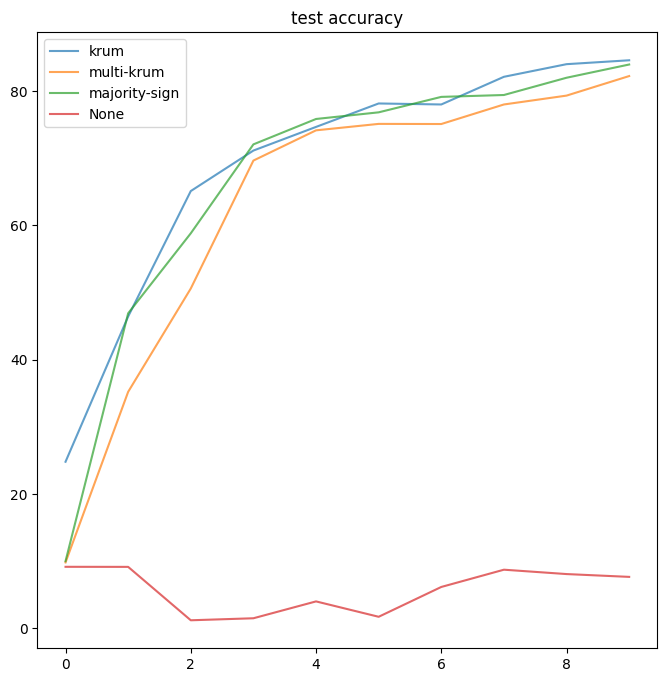

In [23]:
plt.figure(figsize=(8, 8))
plt.title("test accuracy")
for statistics, variant_parameters in zip(results_defense_mechanism_iid, defense_mechanism_variants):
    plt.plot(statistics.test_accuracy, label=f"{variant_parameters}", alpha=0.7)
plt.legend()
# plt.ylim(None, .3)

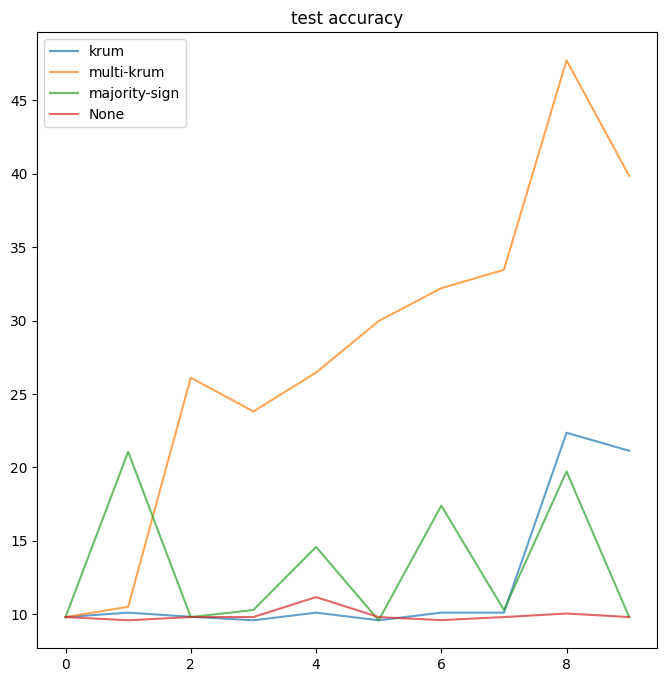

In [24]:
plt.figure(figsize=(8, 8))
plt.title("test accuracy")
for statistics, variant_parameters in zip(results_defense_mechanism_non_iid, defense_mechanism_variants):
    plt.plot(statistics.test_accuracy, label=f"{variant_parameters}", alpha=0.7)
plt.legend()
# plt.ylim(None, .3)

## Question 2: Implementing Bulyan Defense (5 points)

[Bulyan defense](https://arxiv.org/abs/1802.07927) combines aspects of `multi-krum` and `trimmed-mean` to protect against sophisticated attacks in federated environments. In this question, you will implement Bulyan by modifying and combining the existing code in the [attacks_and_defenses.ipynb](https://github.com/lydiaYchen/DDL25Spring/blob/main/lab/tutorial_3/attacks_and_defenses.ipynb).

### Scoring:
- _(1 point)_ Modify the server-side code to integrate a two-step defense process where:
  1. A client-wise defense like `multi-krum` filters out suspicious gradients based on their distance metrics.
  2. A coordinate-wise defense like `trimmed-mean` calculates the mean across the remaining gradients after trimming the extremes.
  
- _(1 point)_ Successfully integrate these two defense mechanisms [`multi-krum`, `trimmed-mean`] to implement the Bulyan.
- _(3 points)_ Evaluate the performance of your implemented Bulyan defense against three types of attacks: `AttackerGradientReversion`, `AttackerPartGradientReversion`, and `AttackerBackdoor`. Vary the defense hyperparameters to make your defense defend against these attacks while keeping the data distribution i.i.d. and the attacker's hyperparameters constant as per the template. Document the performance of your defense strategy against these attacks in your notebook.

In [25]:
class CombinedServerDefense(FedAvgGradServer):
    def __init__(
        self,
        lr: float,
        batch_size: int,
        client_subsets: list,
        client_fraction: float,
        nr_local_epochs: int,
        seed: int,
        defense_client_wise=None,
        defense_coordinate_wise=None,
    ):
        super().__init__(
            lr, batch_size, client_subsets, client_fraction, nr_local_epochs, seed
        )
        self._defense_client_wise = defense_client_wise
        self._defense_coordinate_wise = defense_coordinate_wise

    def _sample_clients(self):
        return self.rng.choice(
            self.nr_clients, self.nr_clients_per_round, replace=False
        )

    def _print_selected_clients(self, client_indices: typing.Iterable[int]) -> None:
        ordered_indices = list(sorted(client_indices))
        malicious_indices = list(
            filter(lambda idx: not is_client_benign(self.clients[idx]), ordered_indices)
        )

        print(
            f"selected clients: {ordered_indices} (whereof {len(malicious_indices) } are malicious)"
        )

    def run(self, nr_rounds: int) -> RunResult:
        # The beginning of the method remains unchanged
        elapsed_time = 0.0
        run_result = RunResult(
            self.name,
            self.nr_clients,
            self.client_fraction,
            self.batch_size,
            self.nr_local_epochs,
            self.lr,
            self.seed,
        )

        # Initial server weights
        server_weights = [param.data.clone() for param in self.model.parameters()]
        for nr_round in tqdm(range(nr_rounds), desc="Rounds", leave=False):
            setup_start_time = perf_counter()
            self.model.train()
            weights = [x.detach().cpu().clone() for x in self.model.parameters()]
            indices_chosen_clients = self._sample_clients()
            elapsed_time += perf_counter() - setup_start_time

            update_time = 0.0
            client_updates: list[tuple[int, ClientUpdate]] = []
            for client_idx in indices_chosen_clients.tolist():
                update_start_time = perf_counter()

                client_round_seed = (
                    self.seed + client_idx + 1 + nr_round * self.nr_clients_per_round
                )
                client_weights = self.clients[client_idx].update(
                    weights, client_round_seed
                )
                client_updates.append((client_idx, client_weights))

                update_time = max(update_time, perf_counter() - update_start_time)

            if self._defense_client_wise is not None:
                selected_indices = self._defense_client_wise(client_updates)
            else:
                # Use all updates if no defense is specified
                selected_indices = range(len(client_updates))

            self._print_selected_clients(indices_chosen_clients[selected_indices].tolist())

            chosen_sum_nr_samples = sum(
                self.client_sample_counts[i]
                for i in indices_chosen_clients[selected_indices]
            )
            chosen_adjusted_weights: list[list[torch.Tensor]] = [
                [
                    self.client_sample_counts[indices_chosen_clients[ind]]
                    / chosen_sum_nr_samples
                    * tens
                    for tens in client_updates[ind][1]
                ]
                for ind in selected_indices
            ]

            averaged_gradients: list[torch.Tensor]
            if self._defense_coordinate_wise is not None:
                averaged_gradients = self._defense_coordinate_wise(chosen_adjusted_weights)
            else:
                # Use torch function for summing up
                averaged_gradients = [sum(x) for x in zip(*chosen_adjusted_weights)]

            # Aggregation logic remains the same from this point onwards
            # Note that chosen_adjusted_weights now only contains updates from clients selected by multi_krum
            elapsed_time += update_time
            aggregate_start_time = perf_counter()

            # Update server model with averaged gradients
            with torch.no_grad():
                for server_weight, gradient in zip(server_weights, averaged_gradients):
                    server_weight -= gradient.to(
                        device=device
                    )  # Assume learning rate is absorbed in gradient

            # Distribute updated weights to clients
            with torch.no_grad():
                for param, server_weight in zip(
                    self.model.parameters(), server_weights
                ):
                    param.data[:] = server_weight.data

            elapsed_time += perf_counter() - aggregate_start_time
            run_result.wall_time.append(round(elapsed_time, 1))
            run_result.message_count.append(
                2 * (nr_round + 1) * self.nr_clients_per_round
            )
            run_result.test_accuracy.append(self.test())

        return run_result

In [26]:
def configure_server(
    dataset: SplitDataset,
    defense_client_wise: typing.Any,
    defense_coordinate_wise: typing.Any,
) -> Server:
    server = CombinedServerDefense(
        lr=0.02,
        batch_size=200,
        client_subsets=dataset,
        client_fraction=0.2,
        nr_local_epochs=2,
        seed=42,
        defense_client_wise=defense_client_wise,
        defense_coordinate_wise=defense_coordinate_wise,
    )

    return server

In [27]:
@dataclass
class BulyanParameters:
    krum_considered_update_count: int
    krum_max_malicious_update_count: int
    mean_beta: float


def run_training_bulyan(
    attack_type: typing.Literal[
        "gradient-reversion", "partial-gradient-reversion", "backdoor"
    ],
    parameters: BulyanParameters,
) -> tuple[RunResult, BackdoorEvaluationResult]:
    dataset = split(nr_clients=100, iid=True, seed=42)

    server = configure_server(
        dataset,
        lambda client_updates: multi_krum(
            client_updates,
            considered_update_count=parameters.krum_considered_update_count,
            total_update_count=20,
            max_malicious_update_count=parameters.krum_max_malicious_update_count,
        ),
        lambda all_updates: trimmed_mean(all_updates, beta=parameters.mean_beta),
    )

    match attack_type:
        case "gradient-reversion":
            inject_malicious_clients(
                server, malicious_client_factory=build_gradient_reversion_client
            )
        case "partial-gradient-reversion":
            inject_malicious_clients(
                server, malicious_client_factory=build_partial_gradient_reversion_client
            )
        case 'backdoor':
            inject_malicious_clients(server, malicious_client_factory=build_backdoor_client)

    return server.run(10), evaluate_backdoor(server.model, test_loader, 10)

In [28]:
variants_bulyan = [
    BulyanParameters(14, 1, 0.05),
    BulyanParameters(14, 1, 0.1),
    BulyanParameters(14, 1, 0.2),
    BulyanParameters(14, 1, 0.3),
    BulyanParameters(14, 5, 0.05),
    BulyanParameters(14, 5, 0.1),
    BulyanParameters(14, 5, 0.2),
    BulyanParameters(14, 5, 0.3),
    BulyanParameters(7, 5, 0.05),
    BulyanParameters(7, 5, 0.1),
    BulyanParameters(7, 10, 0.05),
    BulyanParameters(7, 10, 0.1),
]

In [29]:
results_bulyan: list[RunResult] = []
results_backdoor_bulyan: list[BackdoorEvaluationResult] = []

for variant in tqdm(variants_bulyan, "variant", leave=False):
    result, backdoor_result = run_training_bulyan('backdoor', variant)

    results_bulyan.append(result)
    results_backdoor_bulyan.append(backdoor_result)

variant:   0%|          | 0/12 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 44, 47, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 40, 54, 61, 68, 69, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [7, 8, 9, 11, 30, 40, 50, 54, 56, 59, 60, 69, 75, 85] (whereof 1 are malicious)


selected clients: [2, 8, 15, 29, 31, 35, 37, 57, 68, 73, 74, 84, 87, 94] (whereof 2 are malicious)


selected clients: [7, 9, 28, 43, 44, 62, 69, 73, 77, 79, 81, 83, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 32, 39, 48, 53, 55, 57, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 24, 30, 33, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:   8%|▊         | 1/12 [01:27<16:03, 87.62s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 40, 54, 61, 68, 69, 71, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [7, 8, 9, 11, 40, 50, 54, 56, 59, 60, 69, 77, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 15, 29, 35, 37, 46, 57, 68, 73, 74, 84, 87, 94] (whereof 2 are malicious)


selected clients: [7, 9, 28, 43, 44, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 17, 18, 32, 39, 48, 55, 57, 58, 70, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 34, 40, 43, 44, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 2 are malicious)


selected clients: [9, 13, 21, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 3, 10, 13, 24, 30, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:  17%|█▋        | 2/12 [02:51<14:16, 85.64s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 40, 54, 61, 68, 71, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [8, 9, 11, 20, 30, 40, 50, 54, 60, 69, 75, 77, 85, 94] (whereof 2 are malicious)


selected clients: [2, 8, 15, 29, 31, 35, 37, 46, 57, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 44, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 39, 48, 55, 57, 58, 70, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 24, 34, 40, 43, 44, 54, 60, 66, 77, 79, 87, 91] (whereof 3 are malicious)


selected clients: [13, 21, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 92] (whereof 0 are malicious)


selected clients: [2, 3, 10, 13, 24, 30, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:  25%|██▌       | 3/12 [04:16<12:47, 85.33s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [8, 12, 17, 45, 47, 54, 61, 63, 68, 75, 84, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 40, 54, 61, 68, 69, 71, 75, 79, 86, 87, 97] (whereof 3 are malicious)


selected clients: [8, 9, 11, 20, 30, 40, 50, 54, 60, 69, 75, 77, 85, 94] (whereof 2 are malicious)


selected clients: [2, 8, 15, 29, 31, 35, 37, 46, 57, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 44, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 39, 48, 55, 57, 58, 70, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 24, 34, 40, 43, 44, 54, 60, 66, 77, 79, 87, 91] (whereof 3 are malicious)


selected clients: [9, 13, 21, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 3, 10, 13, 24, 30, 49, 76, 77, 81, 83, 84, 90, 98] (whereof 3 are malicious)


variant:  33%|███▎      | 4/12 [05:44<11:29, 86.22s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  42%|████▏     | 5/12 [07:12<10:09, 87.05s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  50%|█████     | 6/12 [08:41<08:45, 87.51s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  58%|█████▊    | 7/12 [10:09<07:19, 87.87s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 57, 65, 68, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90] (whereof 0 are malicious)


selected clients: [2, 10, 13, 20, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  67%|██████▋   | 8/12 [11:40<05:54, 88.70s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [7, 8, 12, 17, 48, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 54, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 76, 77, 83, 90] (whereof 0 are malicious)


variant:  75%|███████▌  | 9/12 [13:03<04:20, 86.96s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [7, 9, 28, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [12, 17, 18, 48, 55, 58, 89] (whereof 0 are malicious)


selected clients: [7, 15, 34, 54, 77, 91, 95] (whereof 0 are malicious)


selected clients: [9, 54, 62, 84, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 10, 13, 76, 77, 90, 98] (whereof 0 are malicious)


variant:  83%|████████▎ | 10/12 [14:28<02:52, 86.30s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [18, 34, 39, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 50, 54, 69, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 15, 31, 35, 65, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 81, 93] (whereof 0 are malicious)


selected clients: [7, 8, 17, 18, 39, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 90, 92] (whereof 0 are malicious)


selected clients: [30, 66, 76, 77, 81, 83, 84] (whereof 0 are malicious)


variant:  92%|█████████▏| 11/12 [15:52<01:25, 85.67s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 59, 69, 75, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 84, 94] (whereof 0 are malicious)


selected clients: [9, 28, 31, 77, 81, 93, 99] (whereof 0 are malicious)


selected clients: [12, 17, 39, 48, 55, 57, 74] (whereof 0 are malicious)


selected clients: [5, 15, 39, 54, 66, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 55, 92] (whereof 0 are malicious)


selected clients: [8, 13, 76, 77, 81, 83, 90] (whereof 0 are malicious)


In [30]:
results_bulyan_reversion: list[RunResult] = []

for variant in tqdm(variants_bulyan, "variant", leave=False):
    result, _ = run_training_bulyan('gradient-reversion', variant)

    results_bulyan_reversion.append(result)

variant:   0%|          | 0/12 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 36, 37, 40, 54, 68, 69, 71, 75, 76, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 52, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 35, 37, 46, 57, 65, 68, 73, 74, 87, 94] (whereof 2 are malicious)


selected clients: [7, 9, 25, 28, 43, 44, 62, 70, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [3, 7, 18, 32, 39, 48, 51, 55, 57, 58, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 66, 77, 79, 87, 91, 95] (whereof 2 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 49, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:   8%|▊         | 1/12 [01:34<17:20, 94.62s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 54, 68, 69, 71, 75, 76, 86, 87, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 37, 46, 57, 65, 68, 73, 74, 87] (whereof 2 are malicious)


selected clients: [9, 28, 31, 43, 62, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 0 are malicious)


selected clients: [5, 7, 15, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 0 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  17%|█▋        | 2/12 [03:11<16:00, 96.04s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 36, 37, 40, 54, 68, 69, 71, 75, 76, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 46, 57, 65, 68, 70, 74, 84, 87] (whereof 2 are malicious)


selected clients: [9, 28, 31, 43, 62, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 0 are malicious)


selected clients: [5, 7, 15, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 0 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  25%|██▌       | 3/12 [04:58<15:10, 101.19s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 47, 54, 61, 63, 68, 71, 75, 83, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 36, 37, 40, 54, 68, 69, 71, 75, 76, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 46, 57, 65, 68, 70, 74, 84, 87] (whereof 2 are malicious)


selected clients: [7, 9, 28, 31, 43, 69, 70, 77, 79, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [7, 8, 12, 17, 18, 32, 39, 48, 55, 57, 58, 74, 89, 93] (whereof 0 are malicious)


selected clients: [5, 7, 15, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 0 are malicious)


selected clients: [9, 13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  33%|███▎      | 4/12 [06:51<14:06, 105.84s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 36, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 1 are malicious)


variant:  42%|████▏     | 5/12 [08:47<12:45, 109.36s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 47, 51, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 36, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:  50%|█████     | 6/12 [10:47<11:17, 112.95s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 59, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 36, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:  58%|█████▊    | 7/12 [12:51<09:42, 116.51s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 30, 50, 54, 56, 60, 69, 75, 77, 85, 94] (whereof 0 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 30, 33, 36, 66, 76, 77, 81, 83, 84, 98] (whereof 2 are malicious)


variant:  67%|██████▋   | 8/12 [14:57<07:58, 119.73s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [7, 8, 12, 17, 48, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 54, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [8, 13, 30, 66, 81, 84, 90] (whereof 0 are malicious)


variant:  75%|███████▌  | 9/12 [16:54<05:56, 118.71s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [7, 9, 28, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [12, 17, 18, 48, 55, 58, 89] (whereof 0 are malicious)


selected clients: [7, 15, 34, 54, 77, 91, 95] (whereof 0 are malicious)


selected clients: [9, 54, 62, 84, 90, 92, 98] (whereof 0 are malicious)


selected clients: [8, 13, 30, 66, 77, 81, 84] (whereof 0 are malicious)


variant:  83%|████████▎ | 10/12 [18:49<03:55, 117.57s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [18, 34, 39, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 50, 54, 69, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 15, 31, 35, 65, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 81, 93] (whereof 0 are malicious)


selected clients: [7, 8, 17, 18, 39, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 90, 92] (whereof 0 are malicious)


selected clients: [30, 66, 76, 77, 81, 83, 84] (whereof 0 are malicious)


variant:  92%|█████████▏| 11/12 [20:49<01:58, 118.36s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 59, 69, 75, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 84, 94] (whereof 0 are malicious)


selected clients: [9, 28, 31, 77, 81, 93, 99] (whereof 0 are malicious)


selected clients: [12, 17, 39, 48, 55, 57, 74] (whereof 0 are malicious)


selected clients: [5, 15, 39, 54, 66, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 55, 92] (whereof 0 are malicious)


selected clients: [8, 13, 76, 77, 81, 83, 90] (whereof 0 are malicious)


In [31]:
results_bulyan_partial_reversion: list[RunResult] = []

for variant in tqdm(variants_bulyan, "variant", leave=False):
    result, _ = run_training_bulyan('partial-gradient-reversion', variant)

    results_bulyan_partial_reversion.append(result)

variant:   0%|          | 0/12 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 54, 68, 69, 71, 75, 78, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 36, 50, 54, 56, 59, 69, 75, 77, 94] (whereof 2 are malicious)


selected clients: [8, 15, 29, 35, 37, 45, 46, 57, 65, 68, 70, 74, 84, 94] (whereof 2 are malicious)


selected clients: [7, 9, 25, 28, 43, 44, 62, 70, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [7, 17, 18, 32, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89] (whereof 2 are malicious)


selected clients: [5, 7, 15, 24, 34, 40, 43, 44, 45, 54, 60, 77, 91, 95] (whereof 3 are malicious)


selected clients: [9, 21, 22, 23, 28, 37, 54, 62, 67, 81, 84, 85, 89, 90] (whereof 0 are malicious)


selected clients: [2, 8, 13, 20, 36, 45, 49, 66, 77, 81, 83, 84, 90, 98] (whereof 4 are malicious)


variant:   8%|▊         | 1/12 [02:13<24:27, 133.38s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 45, 54, 68, 69, 71, 75, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 20, 30, 36, 50, 54, 56, 59, 69, 75, 77, 85, 94] (whereof 2 are malicious)


selected clients: [8, 15, 29, 35, 37, 45, 46, 57, 65, 68, 73, 74, 84, 94] (whereof 2 are malicious)


selected clients: [7, 9, 24, 28, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 2 are malicious)


selected clients: [3, 7, 8, 18, 32, 39, 48, 51, 53, 55, 57, 58, 74, 89] (whereof 2 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 45, 52, 66, 77, 79, 91] (whereof 3 are malicious)


selected clients: [9, 21, 22, 23, 28, 37, 54, 62, 81, 84, 85, 89, 90, 98] (whereof 0 are malicious)


selected clients: [2, 8, 10, 13, 20, 24, 45, 49, 66, 76, 81, 83, 90, 98] (whereof 4 are malicious)


variant:  17%|█▋        | 2/12 [04:25<22:04, 132.44s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 74, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 45, 54, 68, 69, 71, 75, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 41, 46, 57, 65, 68, 73, 74, 84] (whereof 2 are malicious)


selected clients: [7, 9, 28, 43, 62, 69, 70, 73, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [7, 8, 17, 18, 39, 48, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 43, 52, 60, 77, 79, 91, 95] (whereof 3 are malicious)


selected clients: [9, 13, 21, 22, 28, 37, 54, 55, 62, 81, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [2, 13, 20, 24, 30, 36, 45, 66, 76, 77, 83, 84, 90, 98] (whereof 4 are malicious)


variant:  25%|██▌       | 3/12 [06:36<19:46, 131.79s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 45, 47, 54, 68, 71, 73, 75, 83, 86, 89, 94] (whereof 2 are malicious)


selected clients: [4, 13, 15, 18, 30, 34, 39, 44, 47, 58, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 23, 28, 37, 40, 45, 54, 68, 69, 71, 75, 79, 86, 97] (whereof 3 are malicious)


selected clients: [7, 9, 11, 20, 30, 50, 53, 54, 56, 59, 69, 75, 77, 85] (whereof 2 are malicious)


selected clients: [2, 10, 15, 29, 31, 37, 41, 46, 57, 65, 68, 73, 74, 84] (whereof 2 are malicious)


selected clients: [7, 9, 25, 28, 43, 62, 69, 70, 77, 79, 83, 90, 93, 99] (whereof 2 are malicious)


selected clients: [7, 8, 17, 18, 39, 48, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 2 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 43, 52, 54, 77, 79, 91, 95] (whereof 3 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 89, 90, 92, 98] (whereof 0 are malicious)


selected clients: [2, 13, 20, 24, 30, 36, 45, 66, 76, 77, 83, 84, 90, 98] (whereof 4 are malicious)


variant:  33%|███▎      | 4/12 [08:52<17:48, 133.59s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 59, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [7, 8, 12, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  42%|████▏     | 5/12 [11:07<15:39, 134.23s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 77, 79, 81, 83, 90, 93, 99] (whereof 0 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 7, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 91, 95] (whereof 1 are malicious)


selected clients: [9, 13, 22, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  50%|█████     | 6/12 [13:25<13:31, 135.32s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 47, 51, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 71, 75, 76, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 43, 62, 69, 70, 77, 81, 83, 90, 93, 99] (whereof 1 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  58%|█████▊    | 7/12 [15:42<11:20, 136.08s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 12, 17, 54, 61, 63, 68, 71, 75, 83, 84, 86, 89, 94] (whereof 1 are malicious)


selected clients: [4, 15, 18, 30, 34, 39, 44, 47, 58, 61, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 23, 28, 37, 54, 61, 68, 69, 75, 76, 79, 86, 97] (whereof 1 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 50, 54, 56, 60, 69, 75, 85, 94] (whereof 1 are malicious)


selected clients: [2, 8, 10, 15, 31, 35, 37, 46, 65, 68, 74, 84, 87, 94] (whereof 1 are malicious)


selected clients: [7, 9, 28, 31, 44, 62, 69, 70, 77, 79, 81, 90, 93, 99] (whereof 1 are malicious)


selected clients: [8, 12, 17, 18, 26, 32, 39, 48, 51, 55, 58, 74, 89, 93] (whereof 1 are malicious)


selected clients: [5, 15, 26, 34, 39, 43, 44, 54, 60, 66, 77, 79, 91, 95] (whereof 1 are malicious)


selected clients: [13, 22, 23, 28, 37, 54, 55, 62, 81, 84, 85, 89, 90, 92] (whereof 0 are malicious)


selected clients: [2, 8, 13, 30, 36, 45, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 2 are malicious)


variant:  67%|██████▋   | 8/12 [17:59<09:05, 136.32s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [7, 8, 12, 17, 48, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 54, 84, 89, 92, 98] (whereof 0 are malicious)


selected clients: [8, 66, 76, 77, 81, 84, 98] (whereof 0 are malicious)


variant:  75%|███████▌  | 9/12 [20:04<06:37, 132.61s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [54, 61, 71, 75, 83, 84, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [13, 28, 37, 68, 69, 75, 76] (whereof 0 are malicious)


selected clients: [9, 30, 54, 59, 69, 75, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 74, 94] (whereof 0 are malicious)


selected clients: [7, 9, 28, 69, 77, 90, 93] (whereof 0 are malicious)


selected clients: [12, 17, 18, 48, 55, 58, 89] (whereof 0 are malicious)


selected clients: [7, 15, 34, 54, 77, 91, 95] (whereof 0 are malicious)


selected clients: [9, 54, 62, 84, 90, 92, 98] (whereof 0 are malicious)


selected clients: [8, 13, 66, 76, 81, 83, 84] (whereof 0 are malicious)


variant:  83%|████████▎ | 10/12 [22:09<04:20, 130.36s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [18, 34, 39, 62, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 50, 54, 69, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 15, 31, 35, 65, 94] (whereof 0 are malicious)


selected clients: [9, 28, 44, 69, 77, 81, 93] (whereof 0 are malicious)


selected clients: [7, 8, 17, 18, 39, 55, 74] (whereof 0 are malicious)


selected clients: [7, 34, 54, 66, 77, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 90, 92] (whereof 0 are malicious)


selected clients: [30, 66, 76, 77, 81, 83, 84] (whereof 0 are malicious)


variant:  92%|█████████▏| 11/12 [24:15<02:09, 129.08s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [17, 47, 68, 71, 75, 86, 89] (whereof 0 are malicious)


selected clients: [4, 18, 30, 39, 69, 79, 84] (whereof 0 are malicious)


selected clients: [8, 13, 28, 37, 68, 69, 76] (whereof 0 are malicious)


selected clients: [9, 30, 59, 69, 75, 77, 94] (whereof 0 are malicious)


selected clients: [2, 8, 31, 35, 65, 84, 94] (whereof 0 are malicious)


selected clients: [9, 28, 31, 77, 81, 93, 99] (whereof 0 are malicious)


selected clients: [12, 17, 39, 48, 55, 57, 74] (whereof 0 are malicious)


selected clients: [5, 15, 39, 54, 66, 91, 95] (whereof 0 are malicious)


selected clients: [13, 22, 28, 37, 54, 55, 92] (whereof 0 are malicious)


selected clients: [8, 13, 76, 77, 81, 83, 90] (whereof 0 are malicious)


In [32]:
def _format_bulyan_parameters(parameters: BulyanParameters) -> str:
    return (
        # f"k = {parameters.krum_considered_update_count}, "
        # f"m = {parameters.krum_max_malicious_update_count}, "
        f"beta = {parameters.mean_beta}"
    )


def _plot_bulyan(
    axis,
    title: str,
    results: list[RunResult],
    predicate: typing.Callable[[BulyanParameters], bool],
) -> None:
    axis.title.set_text(title)
    for statistics, variant_parameters in zip(
        results,
        variants_bulyan,
    ):
        if not predicate(variant_parameters):
            continue

        axis.plot(
            statistics.test_accuracy,
            label=_format_bulyan_parameters(variant_parameters),
            alpha=0.7,
        )
    axis.legend()
    axis.set_ylim(20, 90)

In [33]:
def _plot_bulyan_results(results: list[RunResult], attack_name: str):
    fig, axes = plt.subplots(1, 4, figsize=(24, 10))

    fig.suptitle(f"test accuracy ({attack_name} attack, bulyan defense)")
    _plot_bulyan(
        axes.flatten()[0],
        "k = 14, m = 5",
        results,
        lambda it: it.krum_considered_update_count == 14
        and it.krum_max_malicious_update_count == 5,
    )
    _plot_bulyan(
        axes.flatten()[1],
        "k = 14, m = 1",
        results,
        lambda it: it.krum_considered_update_count == 14
        and it.krum_max_malicious_update_count == 1,
    )
    _plot_bulyan(
        axes.flatten()[2],
        "k = 7, m = 5",
        results,
        lambda it: it.krum_considered_update_count == 7
        and it.krum_max_malicious_update_count == 5,
    )
    _plot_bulyan(
        axes.flatten()[3],
        "k = 7, m = 10",
        results,
        lambda it: it.krum_considered_update_count == 7
        and it.krum_max_malicious_update_count == 10,
    )

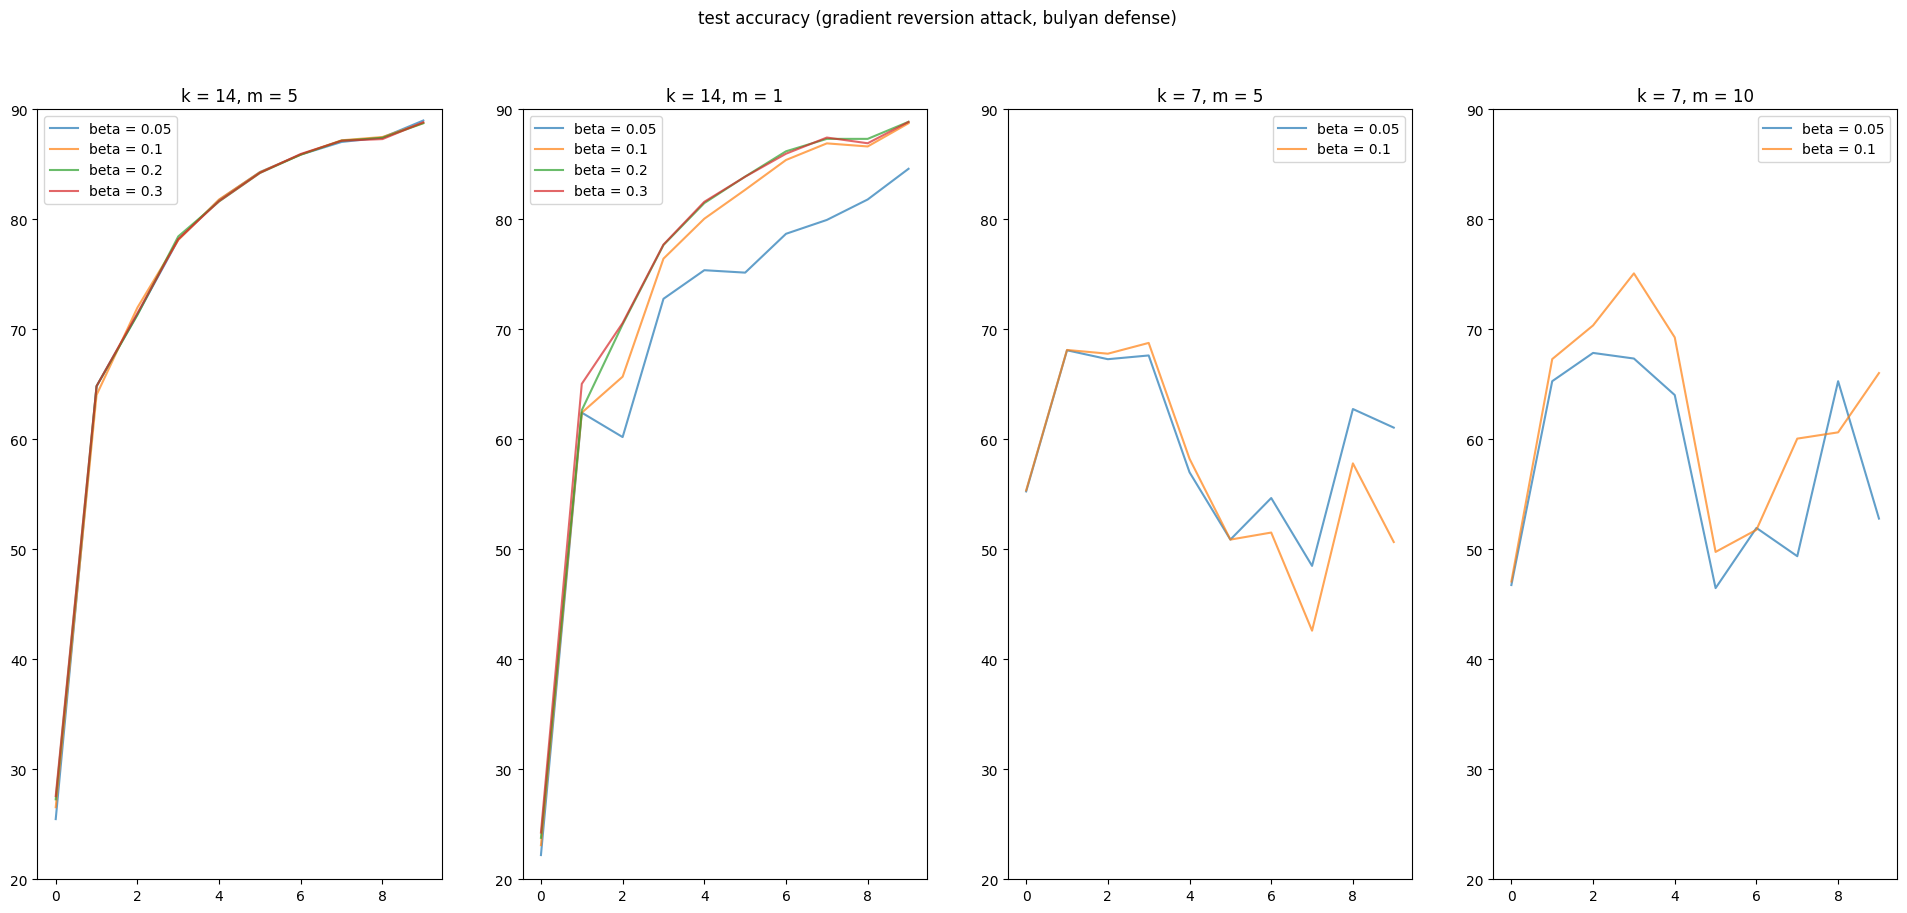

In [34]:
_plot_bulyan_results(results_bulyan_reversion, "gradient reversion")

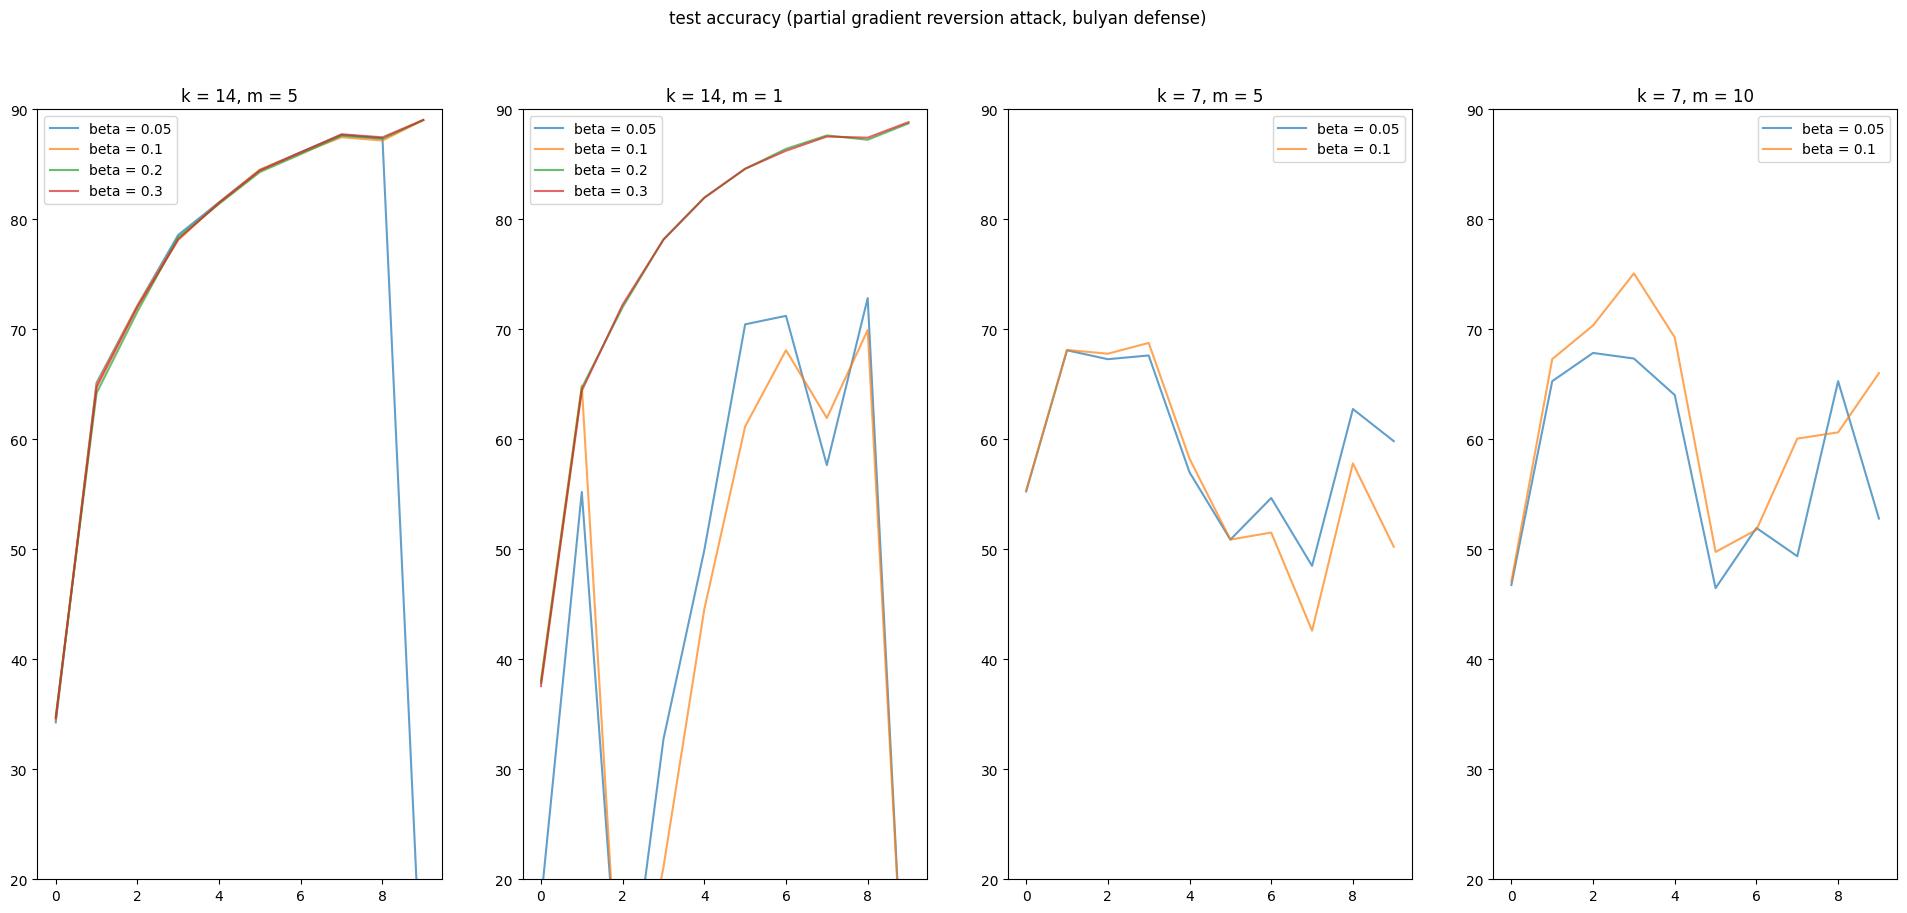

In [35]:
_plot_bulyan_results(results_bulyan_partial_reversion, "partial gradient reversion")

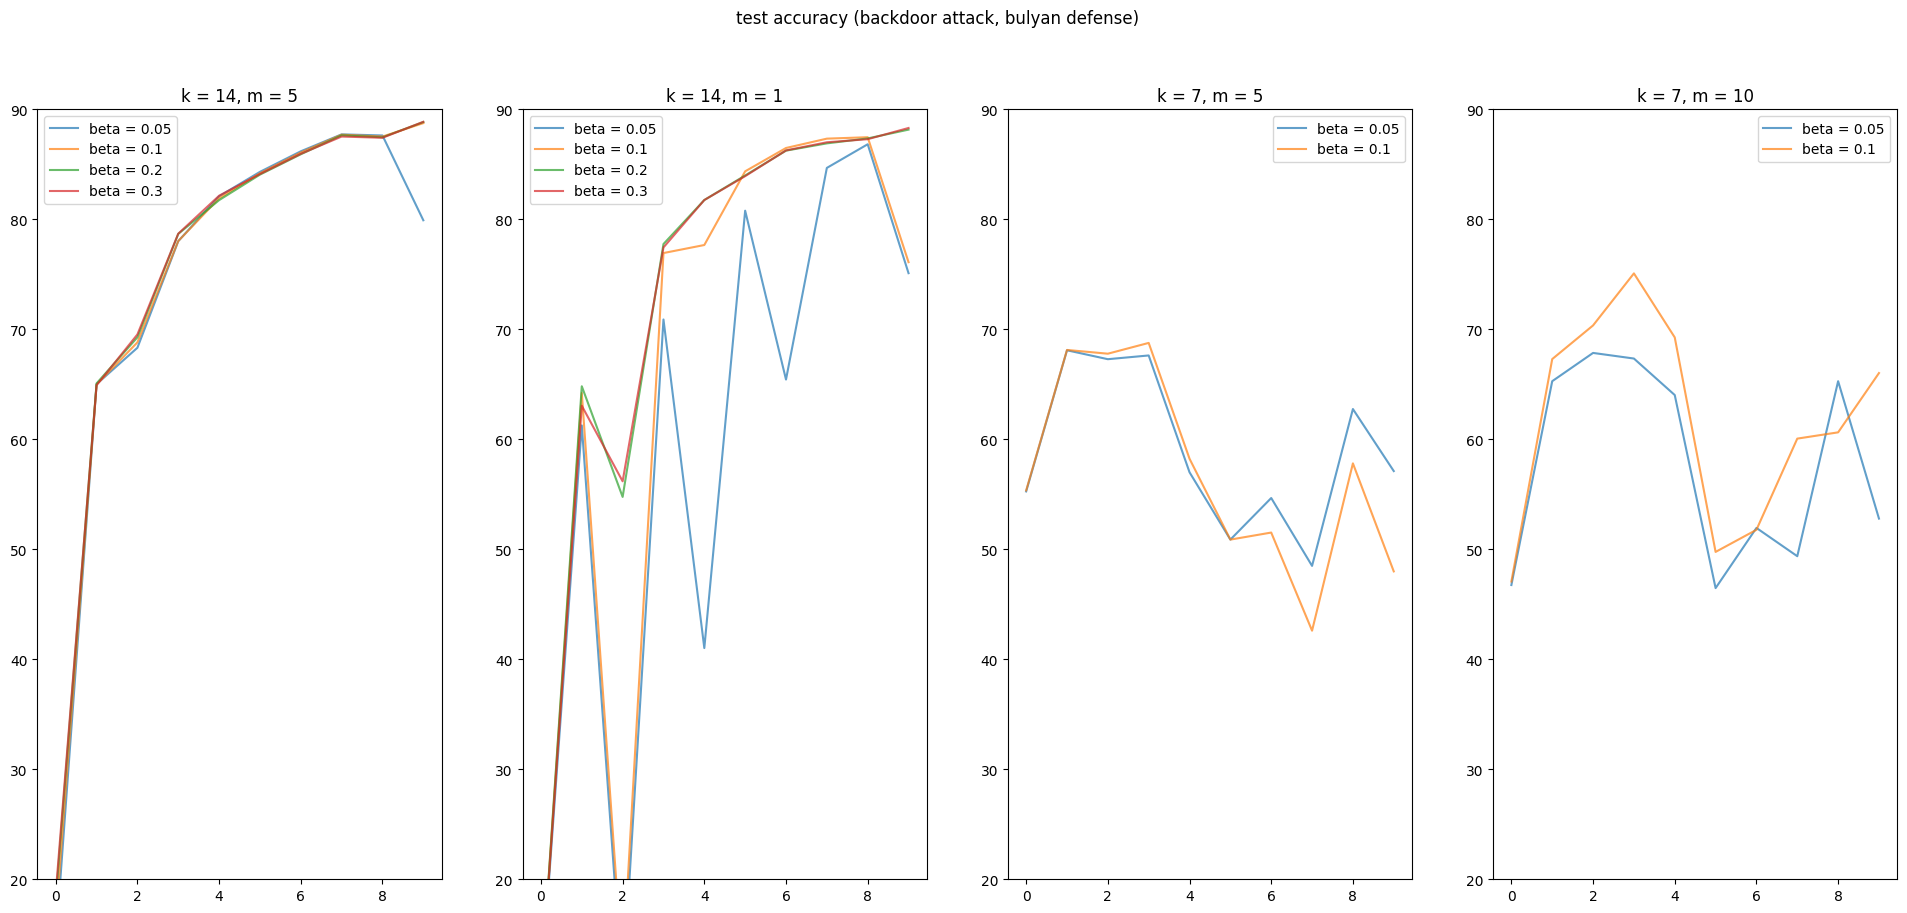

In [36]:
_plot_bulyan_results(results_bulyan, "backdoor")

In [37]:
plot_table({
    "k": list(map(lambda it: it.krum_considered_update_count, variants_bulyan)),
    "m": list(map(lambda it: it.krum_max_malicious_update_count, variants_bulyan)),
    "beta": list(map(lambda it: it.mean_beta, variants_bulyan)),
    "success rate": list(map(lambda it: it.success_rate, results_backdoor_bulyan))
})

,k,m,beta,success rate
0,14,1,0.05,72.12
1,14,1,0.10,36.11
2,14,1,0.20,11.53
3,14,1,0.30,11.40
4,14,5,0.05,25.61
5,14,5,0.10,10.83
6,14,5,0.20,10.60
7,14,5,0.30,10.55
8,7,5,0.05,0.45
9,7,5,0.10,0.08


## Question 3: Implementing SparseFed Defense (7 points)

In this exercise, you will implement the [SparseFed Defense](https://arxiv.org/abs/2112.06274). SparseFed Defense involves two main steps for each participating device during the training process:
1. **Clipping the gradient:** Each device clips its gradient to reduce the impact of potentially malicious updates.
2. **Aggregating top-k updates:** During the aggregation phase, only the gradients with the highest magnitudes (top-k) are considered. This method is designed to minimize the risk of model poisoning by excluding anomalous gradient contributions from potentially compromised devices.

### Scoring:
- _(2 points)_ Implement a simplified version of SparseFed based on the clipping code provided in the template notebook. Unlike the original algorithm which includes momentum, you only need to implement the clipping step and the sparsification step. However, ensure that only the top-k coordinates in the aggregated gradients are selected based on their magnitudes. For example, if the aggregated gradient is `[3, -1, -1, -3]`, selecting the top-2 by magnitude should result in `[3, 0, 0, -3]`.

- _(3 points)_ Evaluate the performance of your implemented SparseFed defense against two types of attacks: `AttackerGradientReversion` and `AttackerBackdoor`. Adjust the values of the defense hyperparameter k to optimize defense effectiveness. Ensure the data distribution remains i.i.d., and the attacker's hyperparameters are unchanged from the template. Document and compare the performance of SparseFed to the simple clipping defense across these attack scenarios. Suggested values for k include percentages of the total parameters, such as 20%, 50%, and 80%.

- _(2 points)_ Analyze and discuss the results to determine if SparseFed provided any improvements. Explain why the sparsefication either succeeded or failed in enhancing the model's robustness against the specified attacks. Include this analysis in your notebook.

In [38]:
def sparse_fed(
    all_updates: list[ClientUpdate], k: float, clip_norm_ratio: float = 1
) -> list[torch.Tensor]:
    clipped_parameters: list[torch.Tensor] = clipping(all_updates, clip_norm_ratio)

    def sparsify_parameter(parameter: torch.Tensor) -> torch.Tensor:
        parameter_shape = parameter.size()
        flattened_parameter = parameter.view(-1)

        retained_components_count = int(flattened_parameter.size(dim=0) * k)
        retained_components = torch.topk(flattened_parameter.abs(), k=retained_components_count)

        sparse_parameter = torch.zeros_like(flattened_parameter)
        sparse_parameter[retained_components.indices] = flattened_parameter[retained_components.indices]

        return sparse_parameter.view(*parameter_shape)

    return [sparsify_parameter(it) for it in clipped_parameters]

In [39]:
def run_training_clipping_sparse_fed(
    attack_type: typing.Literal["gradient-reversion", "backdoor"],
    defense_type: typing.Literal["clipping", "sparse-fed"],
    k: float,
) -> tuple[RunResult, BackdoorEvaluationResult]:
    dataset = split(nr_clients=100, iid=True, seed=42)

    match defense_type:
        case "clipping":
            defense = lambda all_updates: clipping(all_updates)
        case "sparse-fed":
            defense = lambda all_updates: sparse_fed(all_updates, k)

    server = configure_server(
        dataset,
        None,
        defense,
    )

    match attack_type:
        case "gradient-reversion":
            inject_malicious_clients(
                server, malicious_client_factory=build_gradient_reversion_client
            )
        case "backdoor":
            inject_malicious_clients(
                server, malicious_client_factory=build_backdoor_client
            )

    return server.run(10), evaluate_backdoor(server.model, test_loader)

In [40]:
variants_sparse_fed = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.9]

In [41]:
result_clipping, result_backdoor_clipping = run_training_clipping_sparse_fed('backdoor', 'clipping', 0)

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


Rounds:  10%|█         | 1/10 [00:08<01:12,  8.04s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


Rounds:  20%|██        | 2/10 [00:16<01:06,  8.34s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


Rounds:  30%|███       | 3/10 [00:24<00:58,  8.32s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


Rounds:  40%|████      | 4/10 [00:33<00:50,  8.47s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


Rounds:  50%|█████     | 5/10 [00:41<00:42,  8.43s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


Rounds:  60%|██████    | 6/10 [00:49<00:32,  8.22s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


Rounds:  70%|███████   | 7/10 [00:57<00:24,  8.10s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


Rounds:  80%|████████  | 8/10 [01:06<00:16,  8.23s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


Rounds:  90%|█████████ | 9/10 [01:15<00:08,  8.49s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [43]:
results_sparse_fed: list[RunResult] = []
results_backdoor_sparse_fed: list[BackdoorEvaluationResult] = []

for variant in tqdm(variants_sparse_fed, "variant", leave=False):
    result, backdoor_result = run_training_clipping_sparse_fed('backdoor', 'sparse-fed', variant)

    results_sparse_fed.append(result)
    results_backdoor_sparse_fed.append(backdoor_result)

variant:   0%|          | 0/7 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  14%|█▍        | 1/7 [01:05<06:31, 65.17s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  29%|██▊       | 2/7 [02:12<05:31, 66.22s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  43%|████▎     | 3/7 [03:16<04:21, 65.36s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  57%|█████▋    | 4/7 [04:24<03:19, 66.50s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  71%|███████▏  | 5/7 [05:32<02:14, 67.04s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  86%|████████▌ | 6/7 [06:40<01:07, 67.29s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [44]:
result_clipping_reversion, _ = run_training_clipping_sparse_fed('gradient-reversion', 'clipping', 0)

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


Rounds:   0%|          | 0/10 [00:00<?, ?it/s]

selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


Rounds:  10%|█         | 1/10 [00:05<00:47,  5.28s/it]

selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


Rounds:  20%|██        | 2/10 [00:10<00:43,  5.39s/it]

selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


Rounds:  30%|███       | 3/10 [00:15<00:36,  5.14s/it]

selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


Rounds:  40%|████      | 4/10 [00:20<00:29,  4.95s/it]

selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


Rounds:  50%|█████     | 5/10 [00:25<00:25,  5.00s/it]

selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


Rounds:  60%|██████    | 6/10 [00:29<00:19,  4.86s/it]

selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


Rounds:  70%|███████   | 7/10 [00:34<00:14,  4.83s/it]

selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


Rounds:  80%|████████  | 8/10 [00:39<00:09,  4.86s/it]

selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


Rounds:  90%|█████████ | 9/10 [00:44<00:04,  4.95s/it]

selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [45]:
results_sparse_fed_reversion: list[RunResult] = []

for variant in tqdm(variants_sparse_fed, "variant", leave=False):
    result, _ = run_training_clipping_sparse_fed('gradient-reversion', 'sparse-fed', variant)

    results_sparse_fed_reversion.append(result)

variant:   0%|          | 0/7 [00:00<?, ?it/s]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  14%|█▍        | 1/7 [01:01<06:10, 61.71s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  29%|██▊       | 2/7 [02:12<05:34, 66.84s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  43%|████▎     | 3/7 [03:20<04:29, 67.44s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  57%|█████▋    | 4/7 [04:24<03:18, 66.31s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  71%|███████▏  | 5/7 [05:29<02:11, 65.70s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


variant:  86%|████████▌ | 6/7 [06:37<01:06, 66.45s/it]

injected malicious clients at indices: [ 1  3 20 24 25 26 33 36 40 41 45 49 52 53 63 70 73 78 87 97]


selected clients: [7, 8, 12, 17, 36, 45, 47, 49, 54, 61, 63, 68, 71, 73, 75, 83, 84, 86, 89, 94] (whereof 5 are malicious)


selected clients: [4, 5, 13, 15, 18, 30, 34, 39, 44, 47, 51, 53, 58, 61, 62, 69, 70, 74, 79, 84] (whereof 2 are malicious)


selected clients: [8, 13, 23, 28, 36, 37, 40, 45, 54, 61, 68, 69, 71, 75, 76, 78, 79, 86, 87, 97] (whereof 6 are malicious)


selected clients: [7, 8, 9, 11, 20, 30, 36, 40, 50, 52, 53, 54, 56, 59, 60, 69, 75, 77, 85, 94] (whereof 5 are malicious)


selected clients: [2, 8, 10, 15, 29, 31, 35, 37, 41, 45, 46, 57, 65, 68, 70, 73, 74, 84, 87, 94] (whereof 5 are malicious)


selected clients: [7, 9, 24, 25, 28, 31, 41, 43, 44, 62, 69, 70, 73, 77, 79, 81, 83, 90, 93, 99] (whereof 5 are malicious)


selected clients: [3, 7, 8, 12, 17, 18, 26, 32, 36, 39, 48, 51, 53, 55, 57, 58, 70, 74, 89, 93] (whereof 5 are malicious)


selected clients: [5, 7, 15, 24, 26, 34, 39, 40, 43, 44, 45, 52, 54, 60, 66, 77, 79, 87, 91, 95] (whereof 6 are malicious)


selected clients: [3, 9, 13, 20, 21, 22, 23, 28, 37, 54, 55, 62, 67, 81, 84, 85, 89, 90, 92, 98] (whereof 2 are malicious)


selected clients: [2, 3, 8, 10, 13, 20, 24, 30, 33, 36, 45, 49, 66, 76, 77, 81, 83, 84, 90, 98] (whereof 7 are malicious)


In [46]:
def _plot_clipping_sparse_fed(results_sparse_fed: list[RunResult], result_clipping: RunResult, attack_name: str):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(f"test accuracy ({attack_name} attack)")

    for statistics, variant_parameter in zip(results_sparse_fed, variants_sparse_fed):
        axes.flatten()[0].plot(statistics.test_accuracy, label=f"k={variant_parameter}", alpha=0.7)
    axes.flatten()[0].legend()
    axes.flatten()[0].title.set_text("SparseFed")
    # plt.ylim(None, .3)

    axes.flatten()[1].plot(result_clipping.test_accuracy, label=f"<no parameters>", alpha=0.7)
    axes.flatten()[1].title.set_text("clipping")
    axes.flatten()[1].legend()

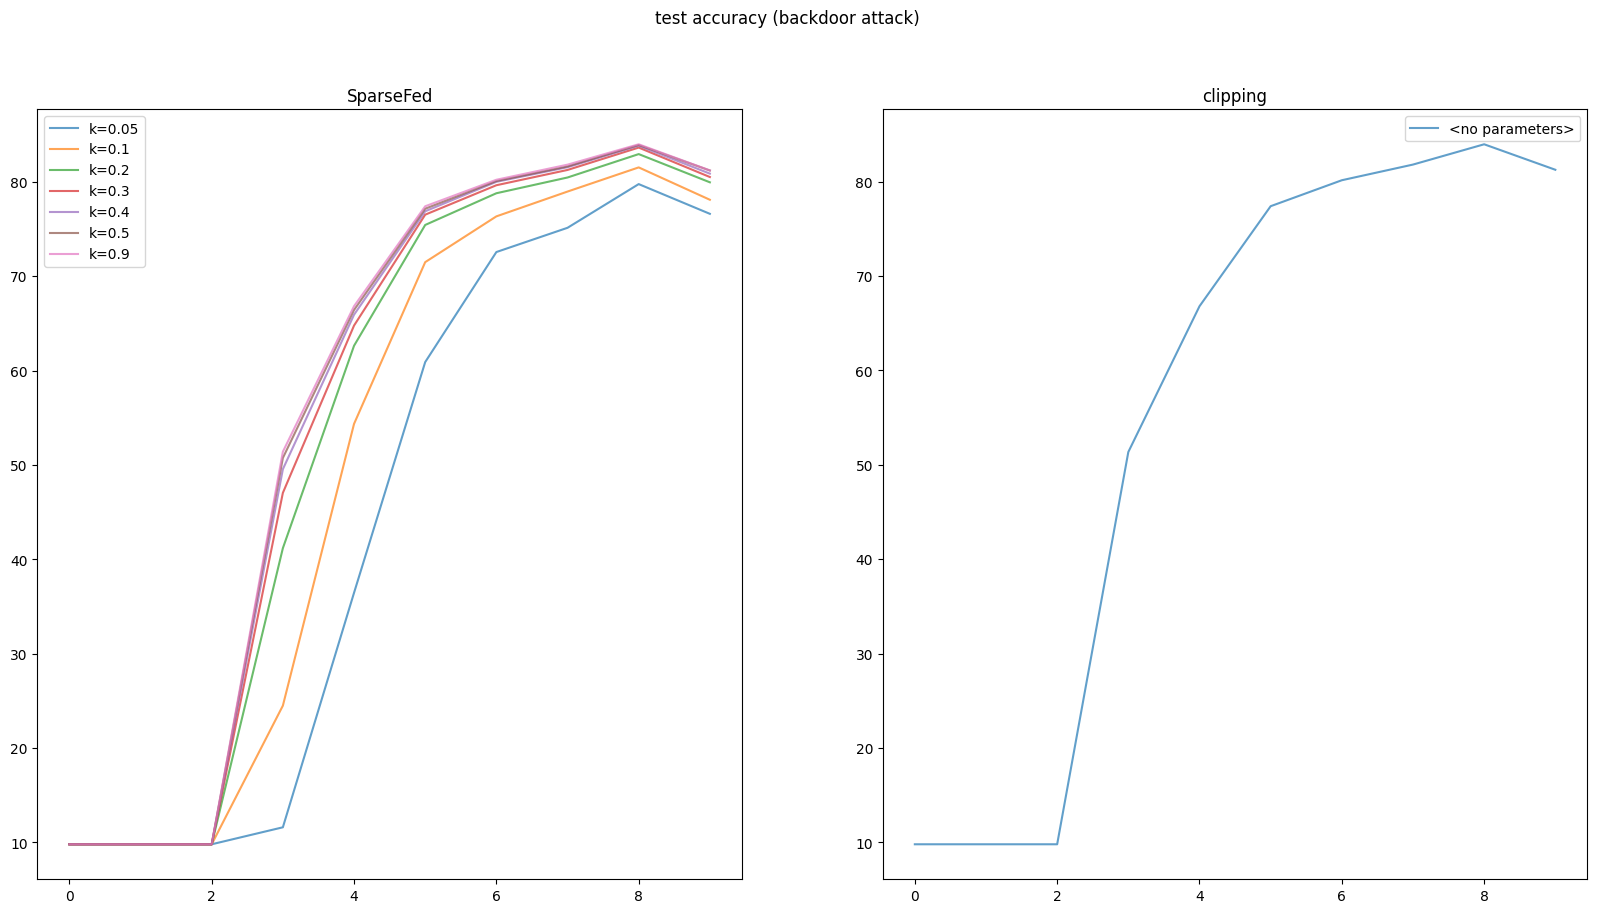

In [47]:
_plot_clipping_sparse_fed(results_sparse_fed, result_clipping, "backdoor")

In [48]:
plot_table(
    {
        "k": variants_sparse_fed,
        "success rate": list(
            map(lambda it: it.success_rate, results_backdoor_sparse_fed)
        ),
    }
)

,k,success rate
0,0.05,75.77
1,0.10,78.34
2,0.20,81.36
3,0.30,83.38
4,0.40,84.45
5,0.50,84.84
6,0.90,85.09


In [49]:
print(f"success rate of backdoor attack with clipping: {result_backdoor_clipping.success_rate}")

success rate of backdoor attack with clipping: 85.06


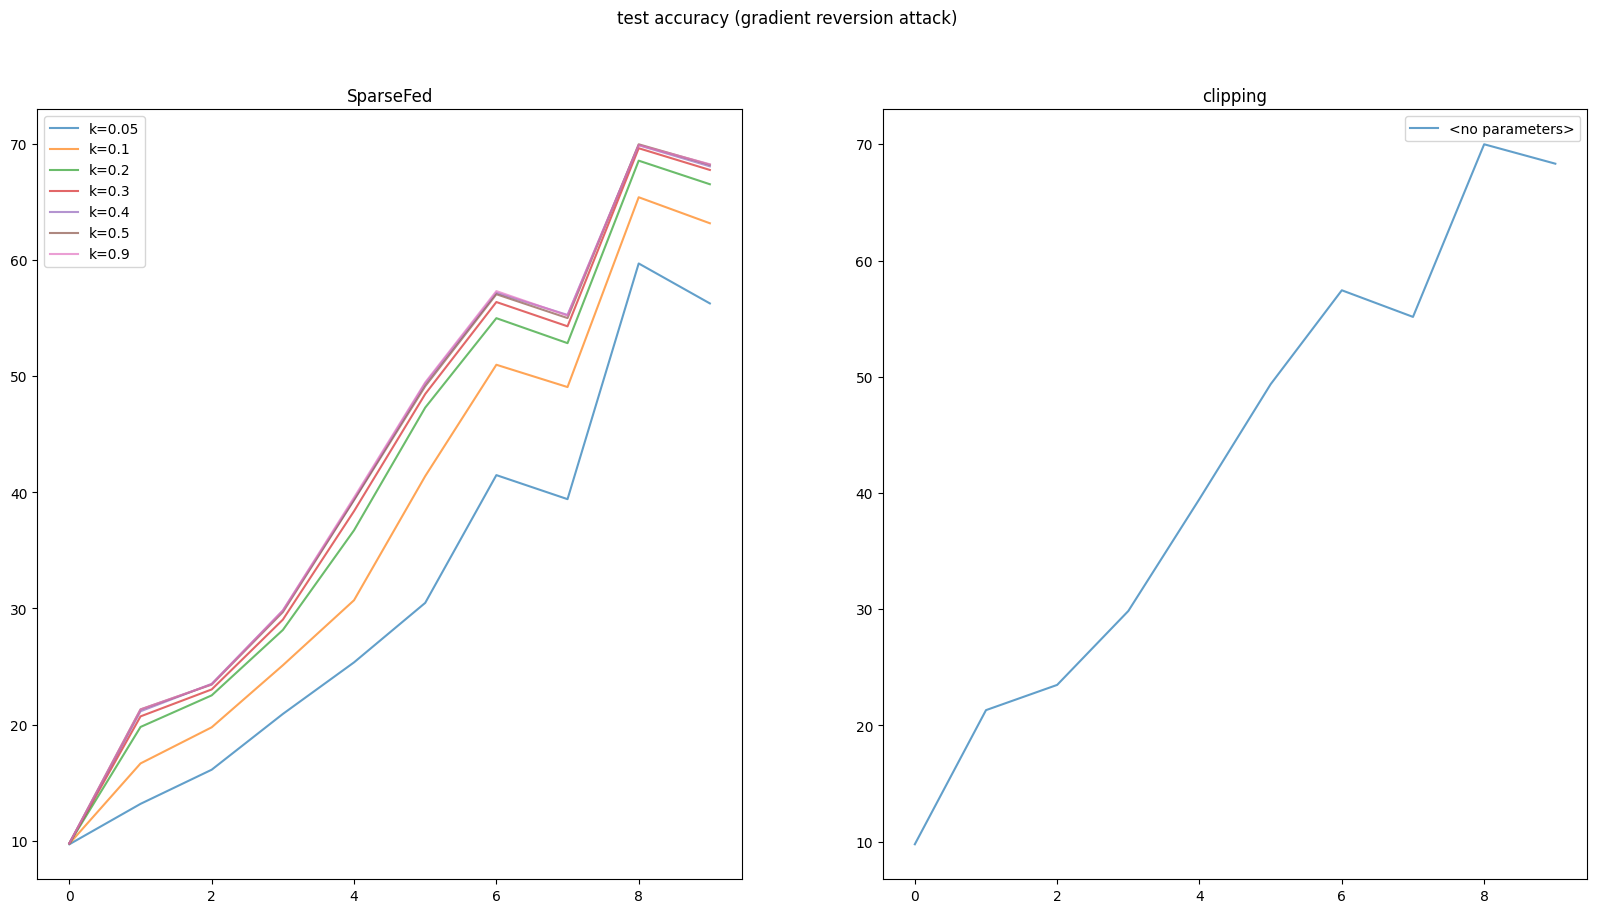

In [50]:
_plot_clipping_sparse_fed(results_sparse_fed_reversion, result_clipping_reversion, "gradient reversion")